In [1]:
import os
import cv2
import random
import shutil
import time
import matplotlib
import glob
import operator
import psutil
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Activation, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization, Conv2D, MaxPooling2D, Flatten, LeakyReLU
from shutil import copyfile
import pandas as pd
import PIL
from mlxtend.plotting import plot_confusion_matrix

In [2]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
for i in physical_devices:
    tf.config.experimental.set_memory_growth(i, True)

In [4]:
classify_train_dir = str(input("Classify Train Dir: "))
classify_train = os.path.join(classify_train_dir, 'classify train')
classify_train_lis = []
for file in os.listdir(classify_train):
    print(os.path.join(classify_train, file))
    classify_train_lis.append(os.path.join(classify_train, file))

Classify Train Dir: /mnt/335fff25-d210-4fe2-8249-4ba8b4a17ce4/DATASETS/Health/cov-cxr/2-class/DATASET
/mnt/335fff25-d210-4fe2-8249-4ba8b4a17ce4/DATASETS/Health/cov-cxr/2-class/DATASET/classify train/training
/mnt/335fff25-d210-4fe2-8249-4ba8b4a17ce4/DATASETS/Health/cov-cxr/2-class/DATASET/classify train/testing
/mnt/335fff25-d210-4fe2-8249-4ba8b4a17ce4/DATASETS/Health/cov-cxr/2-class/DATASET/classify train/validation


In [5]:
classify_train_lis.sort()

In [6]:
classify_train_lis

['/mnt/335fff25-d210-4fe2-8249-4ba8b4a17ce4/DATASETS/Health/cov-cxr/2-class/DATASET/classify train/testing',
 '/mnt/335fff25-d210-4fe2-8249-4ba8b4a17ce4/DATASETS/Health/cov-cxr/2-class/DATASET/classify train/training',
 '/mnt/335fff25-d210-4fe2-8249-4ba8b4a17ce4/DATASETS/Health/cov-cxr/2-class/DATASET/classify train/validation']

In [7]:
TESTING_DIR = classify_train_lis[0]
TRAINING_DIR = classify_train_lis[1]
VALIDATION_DIR = classify_train_lis[2]

In [8]:
TRAINING_DIR, VALIDATION_DIR, TESTING_DIR

('/mnt/335fff25-d210-4fe2-8249-4ba8b4a17ce4/DATASETS/Health/cov-cxr/2-class/DATASET/classify train/training',
 '/mnt/335fff25-d210-4fe2-8249-4ba8b4a17ce4/DATASETS/Health/cov-cxr/2-class/DATASET/classify train/validation',
 '/mnt/335fff25-d210-4fe2-8249-4ba8b4a17ce4/DATASETS/Health/cov-cxr/2-class/DATASET/classify train/testing')

In [9]:
augmentation = []
augment = input(str("Augmenting data will make the model robust but it'll take more time to train. \nDo you want to augment the data?(Y/N) "))

if augment.upper() == 'Y':
    datagen = ImageDataGenerator(
        rescale=1. / 255,
#         rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
#         shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
    augmentation.append('Data is Augmented')

elif augment.upper() == 'N':
    datagen = ImageDataGenerator(
        rescale=1/ 255)
    augmentation.append('Data is not Augmented')



Augmenting data will make the model robust but it'll take more time to train. 
Do you want to augment the data?(Y/N) n


In [10]:
learning_rate = float(input("Enter the initial learning rate: "))
epoch = int(input("Enter the maximum number of epochs: "))
batch_size = int(input("Enter batch size: "))

Enter the initial learning rate: 0.0001
Enter the maximum number of epochs: 100
Enter batch size: 8


In [11]:
char_subfolder_name = str(input("Enter name of sub-folder: "))
char_subfolder = os.path.join(classify_train_dir, char_subfolder_name)

if not os.path.exists(char_subfolder):
    os.mkdir(char_subfolder)
else:
    replace = str(input("Folder already exists ! Do you want to replace it ?(Y/N) "))
    if replace.upper() == 'Y':      
        shutil.rmtree(char_subfolder)
        os.mkdir(char_subfolder)
    else:
        pass

char_name = str(input("Enter name of the characteristics folder: "))

char = os.path.join(classify_train_dir, char_subfolder, char_name)

if not os.path.exists(char):
    os.mkdir(char)
else:
    replace = str(input("Folder already exists ! Do you want to replace it ?(Y/N) "))
    if replace.upper() == 'Y':      
        shutil.rmtree(char)
        os.mkdir(char)
    elif replace.upper() == 'N':
        char_name = str(input("Enter name of the characteristics folder: "))
        char = os.path.join(classify_train_dir, char_subfolder, char_name)
        os.mkdir(char)

Enter name of sub-folder: 128x128
Folder already exists ! Do you want to replace it ?(Y/N) y
Enter name of the characteristics folder: 1


In [12]:
def lr_schedule(epoch):
    return learning_rate * (0.1 ** int(epoch / 10))
    
best_model_address = os.path.join(char, 'best_model.h5')

In [13]:
monitor = int(input("Press 1 to monitor Validation Accuracy\nPress 2 to monitor Validation Loss\nPress 3 to monitor Training Accuracy\nPress 4 to monitor Training Loss\n"))
patience = int(input('Enter number of epochs that will produce monitored quantity with no improvement after which training will be stopped: '))


if monitor == 1:
    metric = 'val_accuracy'
    mode = 'max'
    print("\nMONITORING VALIDATION ACCURACY..........\n")

elif monitor == 2:
    metric = 'val_loss'
    mode = 'min'
    print("\nMONITORING VALIDATION LOSS..........\n")

elif monitor == 3:
    metric = 'accuracy'
    mode = 'max'
    print("\nMONITORING TRAINING ACCURACY..........\n")

elif monitor == 4:
    metric = 'loss'
    mode = 'min'
    print("\nMONITORING TRAINING LOSS..........\n")

callback = [keras.callbacks.LearningRateScheduler(lr_schedule, verbose = 1),
            keras.callbacks.EarlyStopping(monitor = metric, min_delta = 0.001, patience = patience, verbose=1, mode = mode, restore_best_weights = True),
            keras.callbacks.ModelCheckpoint(best_model_address, monitor = metric, verbose=1, save_best_only=True, save_weights_only=False, mode = mode , period=1)]

print("\nTraining will stop if Validation Accuracy doesn't show any improvements for " + str(patience) + " epcohs\n")

Press 1 to monitor Validation Accuracy
Press 2 to monitor Validation Loss
Press 3 to monitor Training Accuracy
Press 4 to monitor Training Loss
4
Enter number of epochs that will produce monitored quantity with no improvement after which training will be stopped: 20

MONITORING TRAINING LOSS..........


Training will stop if Validation Accuracy doesn't show any improvements for 20 epcohs



In [14]:
def Custom_Model_1():
    print("\nTRAINING ON A COMPLEX CUSTOM MODEL:-")

    model = keras.models.Sequential()
    for l in range(layer):
        l += 1
        m = (2**l)//2
        for c in range(conv_layer):
            model.add(Conv2D(conv*m, (conv_size, conv_size), padding = 'same', input_shape = dim, activation = activation))
        model.add(MaxPooling2D(pool_size = (2, 2)))
        model.add(Dropout(dropout))
    model.add(Flatten())
    model.add(Dense(dense, activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(output_layer, activation=output_activation))
    return model

In [15]:
def Custom_Model_2():
    print("\nTRAINING ON A COMPLEX CUSTOM MODEL:-")

    model = keras.models.Sequential()
    for l in range(layer):
        l += 1
        m = (2**l)//2
        for c in range(conv_layer):
            model.add(Conv2D(conv*m, (conv_size, conv_size), padding = 'same', input_shape = dim, activation = activation))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Flatten())
    model.add(Dense(dense, activation=activation))
    model.add(BatchNormalization())
    model.add(Dense(output_layer, activation=output_activation))
    return model

In [16]:
def Custom_Model_3():
    print("\nTRAINING ON A COMPLEX CUSTOM MODEL:-")

    model = keras.models.Sequential()
    for l in range(layer):
        l += 1
        m = (2**l)//2
        for c in range(conv_layer):
            model.add(Conv2D(conv*m, (conv_size, conv_size), padding = 'same', input_shape = dim))
            model.add(LeakyReLU())
        model.add(MaxPooling2D(pool_size = (2, 2)))
        model.add(Dropout(dropout))
    model.add(Flatten())
    model.add(Dense(dense))
    model.add(LeakyReLU())
    model.add(Dropout(dropout))
    model.add(Dense(output_layer, activation=output_activation))
    return model

In [17]:
def Custom_Model_4():
    print("\nTRAINING ON A COMPLEX CUSTOM MODEL:-")

    model = keras.models.Sequential()
    for l in range(layer):
        l += 1
        m = (2**l)//2
        for c in range(conv_layer):
            model.add(Conv2D(conv*m, (conv_size, conv_size), padding = 'same', input_shape = dim))
            model.add(LeakyReLU())
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Flatten())
    model.add(Dense(dense))
    model.add(LeakyReLU())
    model.add(BatchNormalization())
    model.add(Dense(output_layer, activation=output_activation))
    return model

In [18]:
class_no = len(os.listdir(TRAINING_DIR))

print("This is a " + str(class_no) + "-Class Classification")

output_activation = 'softmax'
losses = 'categorical_crossentropy'
class_mode = 'categorical'
output_layer = class_no

This is a 2-Class Classification


In [19]:
def optimizer_selection():
    print("\nSelect a optimizer which will reduce the loss of the model.\n")

    optimizer_select = int(input("Press 1 to select Stochastic Gradient Descent\nPress 2 to select RMSprop\nPress 3 to select Adagrad\nPress 4 to select Adadelta\nPress 5 to select Adam\nPress 6 to select Adamax\nPress 7 to select Nadam\n"))

    if optimizer_select == 1:
        optimizer = keras.optimizers.SGD(lr = learning_rate, decay = 1e-6, momentum = 0.9, nesterov = True)

    elif optimizer_select == 2:
        optimizer = keras.optimizers.RMSprop(learning_rate, rho = 0.9)

    elif optimizer_select == 3:
        optimizer = keras.optimizers.Adagrad(learning_rate)

    elif optimizer_select == 4:
        optimizer = keras.optimizers.Adadelta(learning_rate, rho = 0.95)

    elif optimizer_select == 5:
        optimizer = keras.optimizers.Adam(learning_rate = learning_rate, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)

    elif optimizer_select == 6:
        optimizer = keras.optimizers.Adamax(learning_rate = learning_rate, beta_1 = 0.9, beta_2 = 0.999)

    elif optimizer_select == 7:
        optimizer = keras.optimizers.Nadam(learning_rate = learning_rate, beta_1 = 0.9, beta_2 = 0.999)
   
    return optimizer

In [20]:
h = int(input("Image Dimension(H or W): "))
w = h
color = int(input("Press 1 for RGB \nPress 2 for Grayscale"))
if color == 1:
    color_mode = 'rgb'
    dim = [h,w,3]
elif color == 2:
    color_mode = 'grayscale'
    dim = [h,w,1]

Image Dimension(H or W): 128
Press 1 for RGB 
Press 2 for Grayscale1


In [21]:
train_datagen = datagen
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size = batch_size,
                                                    class_mode = class_mode,
                                                    color_mode = color_mode,
                                                    target_size = (h,w),
                                                    shuffle=True)

validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size = batch_size,
                                                              class_mode = class_mode,
                                                              color_mode = color_mode,
                                                              target_size = (h,w),
                                                              shuffle=True)

test_datagen = ImageDataGenerator(rescale=1.0/255.)
test_generator = test_datagen.flow_from_directory(TESTING_DIR,
                                                  batch_size = batch_size,
                                                  class_mode = class_mode,
                                                  color_mode = color_mode,
                                                  target_size = (h,w),
                                                  shuffle=True)

Found 2128 images belonging to 2 classes.
Found 266 images belonging to 2 classes.
Found 266 images belonging to 2 classes.


In [22]:
dense = int(input("Enter the no. of neurons in dense layer: "))
activation = str(input("Enter the activation function: "))
dropout = float(input("Enter the dropout percentage: "))
dropout = dropout/100

optimizer = optimizer_selection()

Enter the no. of neurons in dense layer: 128
Enter the activation function: relu
Enter the dropout percentage: 40

Select a optimizer which will reduce the loss of the model.

Press 1 to select Stochastic Gradient Descent
Press 2 to select RMSprop
Press 3 to select Adagrad
Press 4 to select Adadelta
Press 5 to select Adam
Press 6 to select Adamax
Press 7 to select Nadam
5


In [23]:
layer = int(input("Enter number of layers you want to apply: "))
conv_layer = int(input("Enter number of convolution layers you want to apply: "))
conv = int(input("Enter the no. of filters in the 1st convolution layer: "))
conv_size = int(input("Enter the size of filters: "))

Enter number of layers you want to apply: 5
Enter number of convolution layers you want to apply: 1
Enter the no. of filters in the 1st convolution layer: 16
Enter the size of filters: 3


In [24]:
model = Custom_Model_3()
model.compile(optimizer = optimizer, loss = losses, metrics = ['accuracy', 
                                                               tf.keras.metrics.Precision(), 
                                                               tf.keras.metrics.Recall(), 
                                                               tf.keras.metrics.TruePositives(), 
                                                               tf.keras.metrics.TrueNegatives(), 
                                                               tf.keras.metrics.FalsePositives(),
                                                               tf.keras.metrics.FalseNegatives()])


model.summary()


TRAINING ON A COMPLEX CUSTOM MODEL:-
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 16)      448       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_1 (M

In [25]:
with tf.device('/GPU:0'):
    start = time.time()
    history = model.fit(train_generator,
                        epochs = epoch,
                        verbose = 1,
                        callbacks = callback,
                        validation_data = validation_generator,
                        shuffle=True)

    end = time.time()
    duration = end-start

train_score = model.evaluate(train_generator)
val_score = model.evaluate(validation_generator)
test_score = model.evaluate(test_generator)

Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
266/266 [==============================] - 13s 13ms/step - loss: 0.6772 - accuracy: 0.5732 - precision: 0.5732 - recall: 0.5732 - true_positives: 654.3895 - true_negatives: 654.3895 - false_positives: 417.5805 - false_negatives: 417.5805 - val_loss: 0.5758 - val_accuracy: 0.7820 - val_precision: 0.7820 - val_recall: 0.7820 - val_true_positives: 208.0000 - val_true_negatives: 208.0000 - val_false_positives: 58.0000 - val_false_negatives: 58.0000

Epoch 00001: loss improved from inf to 0.57812, saving model to /mnt/335fff25-d210-4fe2-8249-4ba8b4a17ce4/DATASETS/Health/cov-cxr/2-class/DATASET/128x128/1/best_model.h5
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0001.
266/266 [==============================] - 3s 9ms/step - loss: 0.3186 - accuracy: 0.8780 - precision: 0.8780 - recall: 0.8780 - true_positives: 943.5993 - true_negatives: 943.5993 - false_positives: 128.3708 - false_

266/266 [==============================] - 3s 10ms/step - loss: 0.0682 - accuracy: 0.9793 - precision: 0.9793 - recall: 0.9793 - true_positives: 1053.5805 - true_negatives: 1053.5805 - false_positives: 18.3895 - false_negatives: 18.3895 - val_loss: 0.0673 - val_accuracy: 0.9887 - val_precision: 0.9887 - val_recall: 0.9887 - val_true_positives: 263.0000 - val_true_negatives: 263.0000 - val_false_positives: 3.0000 - val_false_negatives: 3.0000

Epoch 00013: loss did not improve from 0.04897
Epoch 14/100

Epoch 00014: LearningRateScheduler reducing learning rate to 1e-05.
266/266 [==============================] - 2s 9ms/step - loss: 0.0459 - accuracy: 0.9878 - precision: 0.9878 - recall: 0.9878 - true_positives: 1056.3483 - true_negatives: 1056.3483 - false_positives: 15.6217 - false_negatives: 15.6217 - val_loss: 0.0663 - val_accuracy: 0.9887 - val_precision: 0.9887 - val_recall: 0.9887 - val_true_positives: 263.0000 - val_true_negatives: 263.0000 - val_false_positives: 3.0000 - val_fal


Epoch 00026: loss did not improve from 0.04072
Epoch 27/100

Epoch 00027: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
266/266 [==============================] - 3s 12ms/step - loss: 0.0408 - accuracy: 0.9907 - precision: 0.9907 - recall: 0.9907 - true_positives: 1060.9213 - true_negatives: 1060.9213 - false_positives: 11.0487 - false_negatives: 11.0487 - val_loss: 0.0609 - val_accuracy: 0.9887 - val_precision: 0.9887 - val_recall: 0.9887 - val_true_positives: 263.0000 - val_true_negatives: 263.0000 - val_false_positives: 3.0000 - val_false_negatives: 3.0000

Epoch 00027: loss did not improve from 0.04072
Epoch 28/100

Epoch 00028: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
266/266 [==============================] - 3s 11ms/step - loss: 0.0367 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - true_positives: 1059.0449 - true_negatives: 1059.0449 - false_positives: 12.9251 - false_negatives: 12.9251 - val_loss: 0.0607 - va

34/34 [==============================] - 0s 8ms/step - loss: 0.1206 - accuracy: 0.9699 - precision: 0.9699 - recall: 0.9699 - true_positives: 258.0000 - true_negatives: 258.0000 - false_positives: 8.0000 - false_negatives: 8.0000


In [26]:
print("Execution Time: {} seconds".format(duration))

Execution Time: 158.0467414855957 seconds


In [27]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(len(acc))

In [28]:
xodd = []
xeven = []
i = 0
for i in epochs:
    if i%2 != 0:
        xodd.append(i)
    elif i%2 == 0:
        xeven.append(i)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


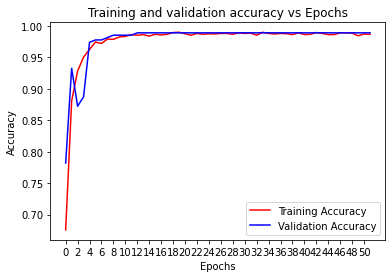

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


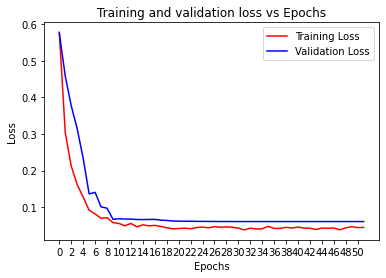

In [29]:
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.xticks(xeven)
plt.ylabel("Accuracy")
plt.title('Training and validation accuracy vs Epochs')
plt.legend()

accuracy_fig_name_eps = "accuracy.eps"
accuracy_fig_name_jpg = "accuracy.jpg"

plt.savefig(os.path.join(char, accuracy_fig_name_eps))
plt.savefig(os.path.join(char, accuracy_fig_name_jpg))

plt.show()


plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.xlabel("Epochs")
plt.xticks(xeven)
plt.ylabel("Loss")
plt.title('Training and validation loss vs Epochs')
plt.legend()

loss_fig_name_eps = "loss.eps"
loss_fig_name_jpg = "loss.jpg"

plt.savefig(os.path.join(char, loss_fig_name_eps))
plt.savefig(os.path.join(char, loss_fig_name_jpg))

plt.show()

In [30]:
training_accuracy = train_score[1]*100
validation_accuracy = val_score[1]*100
test_accuracy = test_score[1]*100

print("The training accuracy is: " + str(training_accuracy) + ' %')
print("The validation accuracy is: " + str(validation_accuracy) + ' %')
print("The test accuracy is: " + str(test_accuracy) + ' %')

The training accuracy is: 98.6372172832489 %
The validation accuracy is: 98.87217879295349 %
The test accuracy is: 96.9924807548523 %


In [31]:
test_accuracy = test_score[1]*100
test_precision = test_score[2]*100
test_recall = test_score[3]*100
tp = int(test_score[4])
tn = int(test_score[5])
fp = int(test_score[6])
fn = int(test_score[7])

f1 = 2*((test_precision*test_recall)/(test_precision+test_recall))
sensitivity = (tp/(tp+fn))*100
specificity = (tn/(tn+fp))*100

In [32]:
print("Test Accuracy: {}".format(test_accuracy))
print("Test Precision: {}".format(test_precision))
print("Test Recall: {}".format(test_recall))
print("True Positive: {}".format(tp))
print("Test Negetive: {}".format(tn))
print("False Positive: {}".format(fp))
print("False Negetive: {}".format(fn))
print("Sensitivity: {}".format(sensitivity))
print("Specificity: {}".format(specificity))

Test Accuracy: 96.9924807548523
Test Precision: 96.9924807548523
Test Recall: 96.9924807548523
True Positive: 258
Test Negetive: 258
False Positive: 8
False Negetive: 8
Sensitivity: 96.99248120300751
Specificity: 96.99248120300751


In [33]:
test_class_list = []
for test_name in os.listdir(TESTING_DIR):
    test = os.path.join(TESTING_DIR, test_name)
    test_class_list.append(test)
test_class_list.sort()

In [44]:
def max_pred(pred):
    pred_categorical = keras.utils.to_categorical(pred)
    if class_no >= 2:
        pred_max = np.argmax(pred)
    else:
        pred_max = np.argmax(pred_categorical)
    return pred_max

In [45]:
y_true = test_generator.classes
labels = test_generator.class_indices

In [46]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


y_pred = []
for i in range(class_no):
    for filename in os.listdir(test_class_list[i]):
        file = os.path.join(test_class_list[i], filename)
        img = image.load_img(file, target_size=(h,w))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)

        images = np.vstack([x])

        pred = model.predict(images, batch_size = batch_size)
        pred_max = max_pred(pred)
        
        y_pred.append(pred_max)

In [47]:
labels

{'covid': 0, 'normal': 1}

In [48]:
print("Calculating CLASSIFICATION REPORT: ")
classification_report = classification_report(y_true, y_pred, target_names=labels)
print(classification_report)

print("\nCalculating SENSITIVITY & SPECIFICITY..........:")
cm = confusion_matrix(y_true, y_pred)
total = sum(sum(cm))
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print("sensitivity = {:.4f}".format(sensitivity))
print("specificity = {:.4f}".format(specificity))

Calculating CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

       covid       0.98      0.90      0.94       133
      normal       0.91      0.98      0.94       133

    accuracy                           0.94       266
   macro avg       0.94      0.94      0.94       266
weighted avg       0.94      0.94      0.94       266


Calculating SENSITIVITY & SPECIFICITY..........:
sensitivity = 0.9023
specificity = 0.9774


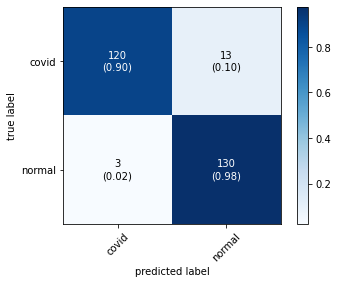

In [49]:
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                colorbar=True,
                                show_absolute=True,
                                class_names=labels,
                                show_normed=True)

plt.savefig(os.path.join(char, 'cm.eps'))
plt.savefig(os.path.join(char, 'cm.jpg'))

plt.show()

In [50]:
labels

{'covid': 0, 'normal': 1}

In [51]:
for i in range(class_no):
    for filename in os.listdir(test_class_list[i]):
        file = os.path.join(test_class_list[i], filename)
        img = image.load_img(file, target_size=(h,w))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)

        images = np.vstack([x])

        pred = model.predict(images, batch_size = batch_size)
        pred_max = max_pred(pred)
        
        print(filename, pred)
        break

COVID-19 (518).jpg [[1. 0.]]
NORMAL2-IM-1294-0001-0002.jpeg [[0. 1.]]


In [52]:
from contextlib import redirect_stdout

readme_name_text = "readme.txt"
print("Please read the text file named " + readme_name_text + " for detailed information of the model.")

completeName_txt = os.path.join(char, readme_name_text) 

readme = open(completeName_txt, "w")

if len(os.listdir(TRAINING_DIR)) > 2:
    readme.write("This is a {}-class CLASSIFICATION".format(len(os.listdir(TRAINING_DIR))))
else:
    readme.write("This is a BINARY CLASSIFICATION")


readme.write("\n\n--HYPERPARAMETERS--\n")
readme.write("\nInitial Learning Rate = " + str(learning_rate))
readme.write("\nNo. of epochs = " + str(len(acc)))
readme.write("\nBatch Size = " + str(batch_size))


readme.write("\n\n--MODEL-PARAMETERS--")
readme.write("\nActivation Function = relu")
readme.write("\nDropout = " + str(int(dropout*100)) + "%")
readme.write("\nActivation function of the output layer = " + str(output_activation))
readme.write("\nCost function of the model = " + str(losses))
readme.write("\nOptimizer = " + str(optimizer) + "\n\n")


readme.write("Trained on a Custom Prebuilt Model\n")
readme.write("Number of Conv layer = " + str(conv_layer))
readme.write("\nFilter size = " + str(conv_size)+ "*" + str(conv_size) + "\n\n")
with redirect_stdout(readme):
    model.summary()
        
    
readme.write("\n\n--MODEL-PERFORMANCE--")
readme.write("\nTest Accuracy = " + str(test_accuracy) + " %")
readme.write("\nTest Precision = " + str(test_precision) + " %")
readme.write("\nTest Recall = " + str(test_recall) + " %")
readme.write("\nTrue Positive = " + str(tp))
readme.write("\nTrue Negetive = " + str(tn))
readme.write("\nFalse Positive = " + str(fp))
readme.write("\nFalse Negetive = " + str(fn))
readme.write("\nSensitivity = " + str(sensitivity))
readme.write("\nSpecificity = " + str(specificity) + " \n\n\n")


readme.write("\n\n--MODEL-CHARACTERISTICS--")
readme.write("\nacc = " + str(acc))
readme.write("\n\nval_acc = " + str(val_acc))
readme.write("\n\nloss = " + str(loss))
readme.write("\n\nval_loss = " + str(val_loss))


readme.write("\n\n--Classification Report--\n")
readme.write(classification_report)

readme.write("\nSensitivity = " + str(int(sensitivity*100)) + " %")
readme.write("\nSpecificity = " + str(int(specificity*100)) + " %")


readme.write("\nExecution Time: {} seconds".format(duration))

readme.write("\n\nCreated using Self-Regulated Image Classifier using Convolution Neural Network")

readme.close()

Please read the text file named readme.txt for detailed information of the model.
